# **TextTorch - 04: Treinamento do Modelo**

**Objetivo:** Treinar o classificador de texto usando os dados processados e a arquitetura definida. Este notebook inclui um **smoke test** para verificação rápida e o loop de treinamento completo.

### **Como Executar (Google Colab)**

1. **Pré-requisito:** Execute os notebooks `01`, `02` e `03`.
2. **Ambiente:** Se estiver em um novo ambiente, clone o repositório e instale as dependências.
   ```bash
   !git clone https://github.com/takaokensei/TextTorch.git
   %cd TextTorch
   !pip install -r requirements.txt
   ```
3. **Execução:** Execute todas as células. O treinamento pode levar alguns minutos, dependendo do hardware (CPU vs. GPU).

In [1]:
# Imports e Configurações Iniciais
import sys
import os
import torch

# Adiciona o diretório 'src' ao path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from model import create_model, load_config
from train import Trainer, create_dataloader, get_device, set_seed, smoke_test
from evaluate import plot_training_curves

# Carrega configurações
CONFIG_PATH = '../models/config.yaml'
config = load_config(CONFIG_PATH)
set_seed(config['seed'])

# Carrega tensores
TENSORS_PATH = f"../artifacts/tensors_{config['representation']}.pt"
data = torch.load(TENSORS_PATH)

# Define dispositivo
device = get_device()

print(f"Ambiente configurado. Usando dispositivo: {device}")

2025-11-13 17:29:30,847 - INFO - Configuração carregada de: ../models/config.yaml
2025-11-13 17:29:30,852 - INFO - Seeds definidas: 42
2025-11-13 17:29:30,856 - INFO - Dispositivo detectado: cpu


Ambiente configurado. Usando dispositivo: cpu


## 1. Preparação para o Treinamento

Instanciamos o modelo e criamos os `DataLoaders` para os conjuntos de treino e validação. Os `DataLoaders` são responsáveis por agrupar os dados em batches e embaralhá-los a cada época.

In [2]:
# Cria o modelo
model = create_model(
    input_dim=data['input_dim'],
    n_classes=data['n_classes'],
    config=config
)

# Cria DataLoaders
train_loader = create_dataloader(data['X_train'], data['y_train'], batch_size=config['batch_size'], shuffle=True)
val_loader = create_dataloader(data['X_val'], data['y_val'], batch_size=config['batch_size'], shuffle=False)

print(f"Modelo e DataLoaders criados. Batch size: {config['batch_size']}")

2025-11-13 17:29:44,646 - INFO - TFIDFClassifier criado: input=676, hidden=512, output=6


Modelo e DataLoaders criados. Batch size: 32


## 2. Smoke Test

Antes do treinamento completo, executamos um **smoke test**: treinamos o modelo por uma única época em uma pequena amostra de dados. Isso serve para:
- Verificar se o loop de treinamento funciona sem erros.
- Garantir que a loss diminui (um sinal de que o modelo está aprendendo).
- Ter uma estimativa rápida do tempo por época.

In [3]:
# Pega uma amostra para o smoke test
X_sample = data['X_train'][:200]
y_sample = data['y_train'][:200]

# Cria um novo modelo para o teste para não "sujar" o modelo principal
smoke_model = create_model(data['input_dim'], data['n_classes'], config)

# Executa o smoke test
smoke_history = smoke_test(smoke_model, X_sample, y_sample, device=device, n_epochs=1)

2025-11-13 17:29:48,830 - INFO - TFIDFClassifier criado: input=676, hidden=512, output=6
2025-11-13 17:29:48,831 - INFO - === SMOKE TEST ===
2025-11-13 17:29:48,832 - INFO - Amostra: 200 documentos, 1 época(s)
2025-11-13 17:29:50,006 - INFO - Trainer inicializado: lr=0.001, weight_decay=0.0001
2025-11-13 17:29:50,007 - INFO - Iniciando treinamento: 1 épocas
Treinamento: 100%|██████████| 13/13 [00:00<00:00, 504.78it/s]
2025-11-13 17:29:50,036 - INFO - Época 1/1 - Train Loss: 1.7693, Train Acc: 0.3300
2025-11-13 17:29:50,042 - INFO - Treinamento concluído em 0.00 minutos
2025-11-13 17:29:50,043 - INFO - Predições de exemplo: [3 3 1 1 1]
2025-11-13 17:29:50,044 - INFO - Labels reais: [3 3 1 5 1]
2025-11-13 17:29:50,045 - INFO - Loss final: 1.7693
2025-11-13 17:29:50,045 - INFO - === SMOKE TEST CONCLUÍDO ===



## 3. Treinamento Completo

Agora, treinamos o modelo no conjunto de dados completo. O `Trainer` gerencia:
- O loop de épocas.
- O cálculo de loss e accuracy.
- **Early Stopping:** Interrompe o treinamento se a loss de validação não melhorar por um número definido de épocas (`patience`).
- **Salvamento do Melhor Modelo:** Salva automaticamente o modelo com a menor loss de validação.

In [4]:
# Inicializa o Trainer
trainer = Trainer(
    model=model,
    device=device,
    learning_rate=config['learning_rate'],
    weight_decay=config.get('weight_decay', 0.0)
)

# Caminho para salvar o modelo
SAVE_PATH = f"../models/{config['representation']}_model.pt"

# Inicia o treinamento
history = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=config['epochs'],
    early_stopping=config.get('early_stopping', True),
    patience=config.get('patience', 3),
    save_path=SAVE_PATH
)

2025-11-13 17:29:58,421 - INFO - Trainer inicializado: lr=0.001, weight_decay=0.0001
2025-11-13 17:29:58,422 - INFO - Iniciando treinamento: 10 épocas
Treinamento: 100%|██████████| 8/8 [00:00<00:00, 484.66it/s]
2025-11-13 17:29:58,441 - INFO - Época 1/10 - Train Loss: 1.7748, Train Acc: 0.4405 | Val Loss: 1.7448, Val Acc: 0.8387
2025-11-13 17:29:58,447 - INFO -   → Melhor modelo salvo (val_loss: 1.7448)
Treinamento: 100%|██████████| 8/8 [00:00<00:00, 465.78it/s]
2025-11-13 17:29:58,468 - INFO - Época 2/10 - Train Loss: 1.7017, Train Acc: 0.8849 | Val Loss: 1.6761, Val Acc: 0.8387
2025-11-13 17:29:58,474 - INFO -   → Melhor modelo salvo (val_loss: 1.6761)
Treinamento: 100%|██████████| 8/8 [00:00<00:00, 197.57it/s]
2025-11-13 17:29:58,520 - INFO - Época 3/10 - Train Loss: 1.5958, Train Acc: 0.9563 | Val Loss: 1.5672, Val Acc: 0.8710
2025-11-13 17:29:58,527 - INFO -   → Melhor modelo salvo (val_loss: 1.5672)
Treinamento: 100%|██████████| 8/8 [00:00<00:00, 308.33it/s]
2025-11-13 17:29:58,5

## 4. Análise das Curvas de Treinamento

Visualizar as curvas de loss e acurácia é fundamental para diagnosticar o comportamento do treinamento (ex: overfitting, underfitting).

In [5]:
# Salva o histórico para uso posterior
HISTORY_PATH = '../artifacts/training_history.pkl'
import pickle
with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(history, f)

# Plota as curvas
plot_training_curves(history, save_path='../artifacts/plots/training_curves.png')

print(f"Gráfico das curvas de treinamento salvo.")

2025-11-13 17:30:10,150 - INFO - Curvas de treinamento salvas em: ../artifacts/plots/training_curves.png


Gráfico das curvas de treinamento salvo.


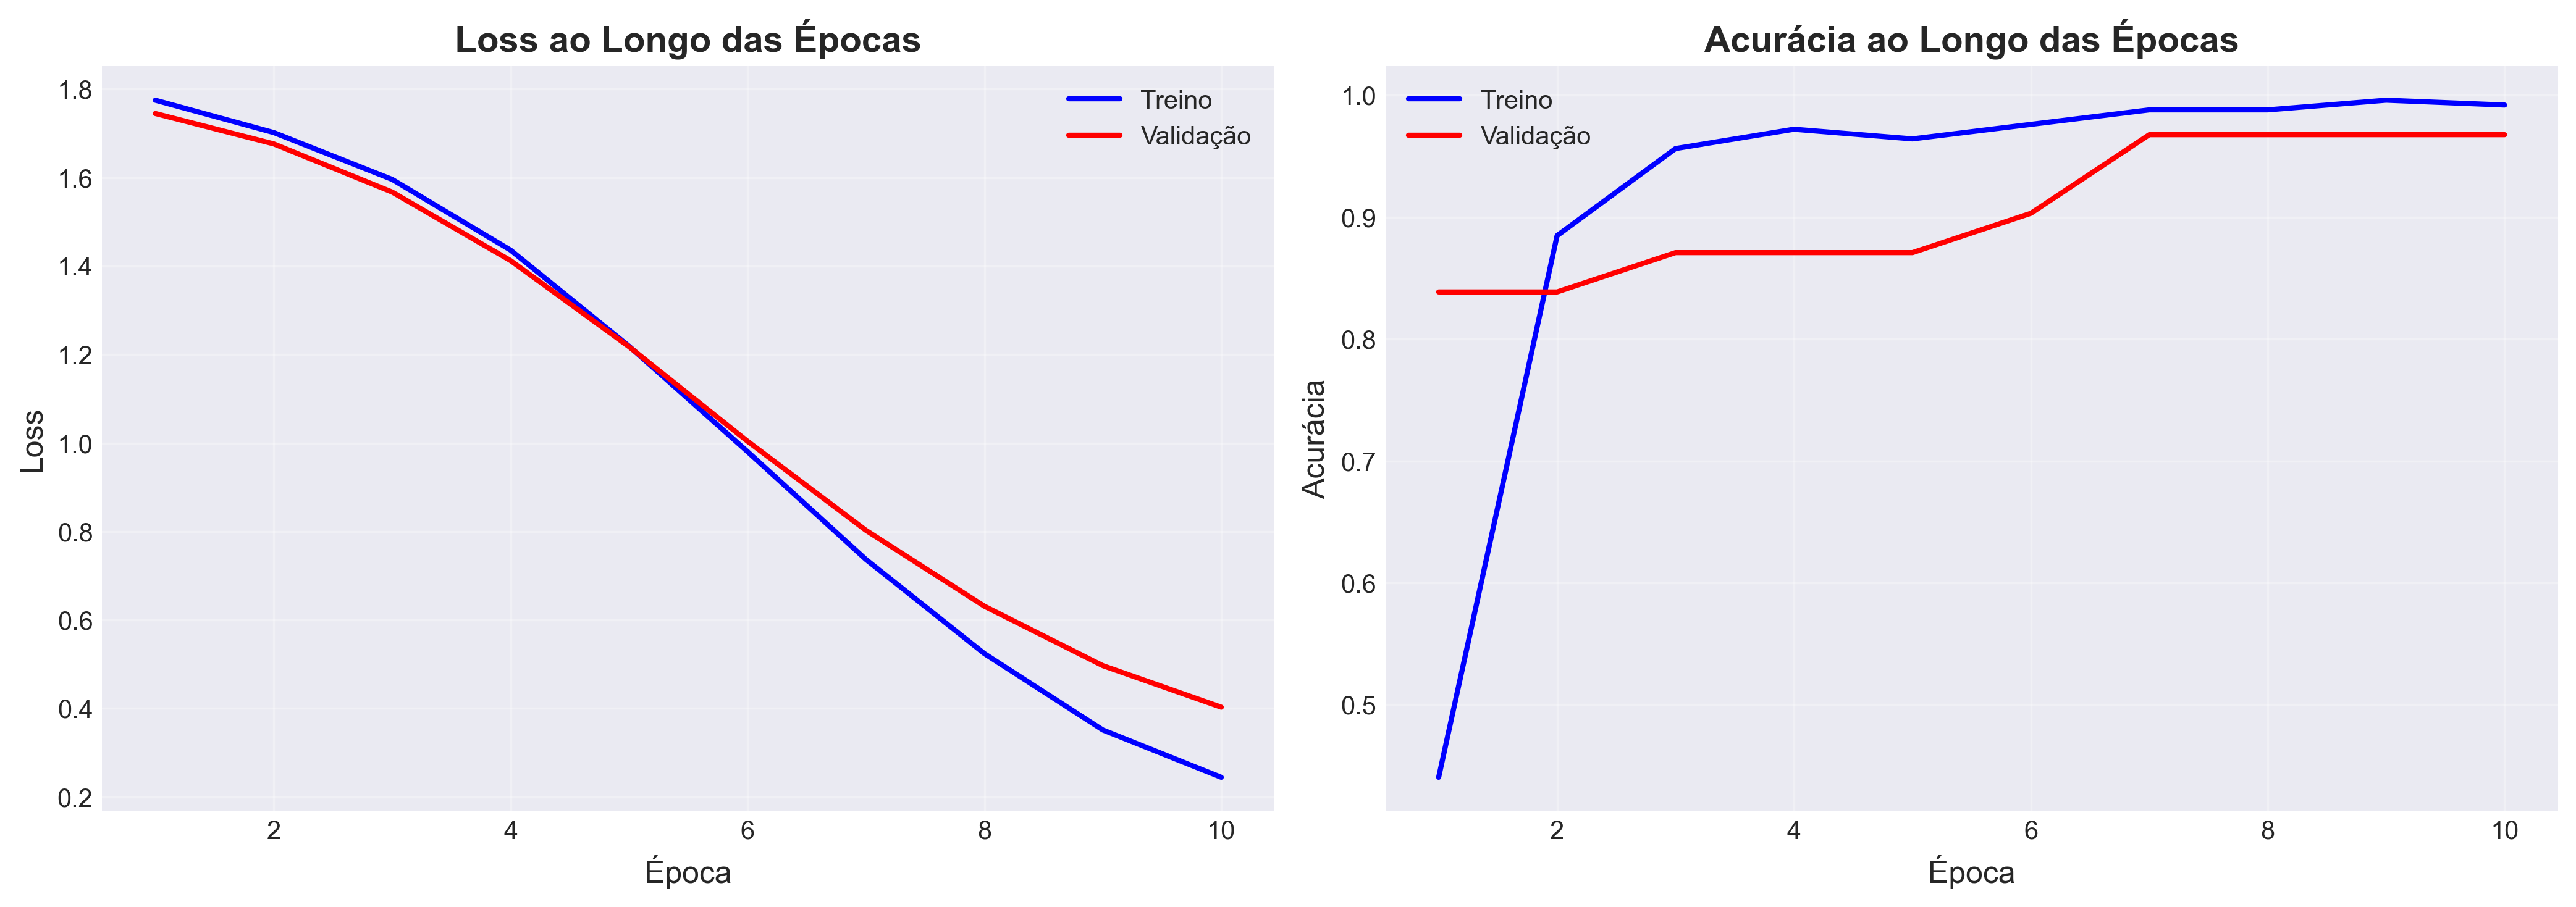

In [6]:
# Exibe a imagem gerada
from IPython.display import Image
Image(filename='../artifacts/plots/training_curves.png')